In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [18]:
import warnings
def read_data():
    data=pd.read_csv("./seattle-weather.csv")
    print(data.head())
    print(data[["precipitation","temp_max","temp_min","wind"]].describe())
    warnings.filterwarnings('ignore')
    print(data.isna().sum())
    sns.countplot("weather", data=data,palette="hls")
    return data

         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain
       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000
date             0
precipitation    0
temp_max         0
temp_min         0


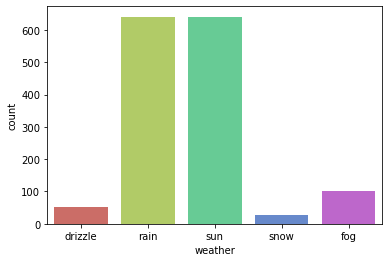

In [19]:
data = read_data()

In [52]:
def process_data(data):
    # 日付削除
    df = data.drop(["date"], axis=1)
    # 目的変数のラベル化
    # 0:drizzle 1:fog  2:rain  3:snow  4:sun
    le=LabelEncoder()
    df["weather"]=le.fit_transform(df["weather"])
    # 説明変数と目的変数の名前を取得
    weather_labels = np.array(df["weather"])
    feature_names = list(df.drop("weather", axis = 1).columns)
    # データ分割
    X = ((df.loc[:,df.columns != "weather"]).astype(int)).values[:,0:]
    y = df["weather"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    return feature_names, X_train, X_test, y_train, y_test

In [53]:
feature_names, X_train, X_test, y_train, y_test = process_data(data)

In [26]:
def create_model(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state=1234)
    rf.fit(X_train, y_train)
    print("Score: ", rf.score(X_test, y_test))

In [27]:
create_model(X_train, X_test, y_train, y_test)

Score:  0.724373576309795


In [34]:
def param_tuning(X_train, y_train):
    rf = RandomForestClassifier()
    # ハイパーパラメータ探索の候補
    parameters = {
        'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15],
        'max_features': ['sqrt', 'log2', 'auto', None],
        'max_depth': [1, 3, 5, 7, 9, 11, 13, 15]
    }
    gridsearch = GridSearchCV(estimator = rf,
                              param_grid = parameters,
                              scoring = "accuracy")
    # グリッドサーチ実行
    gridsearch.fit(X_train, y_train)
    # 最適なパラメータを表示
    print(f"Best params: {gridsearch.best_params_}")
    print(f"Best Score: {gridsearch.best_score_}")
    return gridsearch

In [35]:
gridsearch = param_tuning(X_train, y_train)

Best params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 9}
Best Score: 0.7896126255380201


In [38]:
def recreate_model(gridsearch, X_train, X_test, y_train, y_test):
    # 最適なハイパーパラメータの組み合わせでモデルを再構築
    rf = RandomForestClassifier(n_estimators = gridsearch.best_params_['n_estimators'], # 用意する決定木モデルの数
                               max_features = gridsearch.best_params_['max_features'], # ランダムに指定する特徴量の数
                               max_depth    = gridsearch.best_params_['max_depth'],    # 決定木のノード深さの制限値
                               criterion='gini',                                       # 不純度評価指標の種類(ジニ係数）
                               min_samples_leaf = 1,                                   # 1ノードの深さの最小値
                               random_state = 0,                                       # 乱数シード
                              )
    # モデル学習
    rf.fit(X_train, y_train)
    # スコア表示
    print("Score: ", rf.score(X_test, y_test))
    return rf

In [40]:
rf = recreate_model(gridsearch, X_train, X_test, y_train, y_test)

Score:  0.7722095671981777


In [44]:
def predict_weather(input):
    ans = rf.predict(input)
    print("The weather is:")
    if(ans == 0):
        print("Drizzle")
    elif(ans == 1):
        print("Fog")
    elif(ans == 2):
        print("Rain")
    elif(ans == 3):
        print("Snow")
    else:
        print("Sun")

In [47]:
predict_weather([[0.0,12.8,5.0,4.7]])

The weather is:
Sun


In [86]:
from sklearn import tree
def show_graph(rf, i):
    plt.figure(figsize=(80,80))
    tree.plot_tree(rf.estimators_[i], proportion=True, feature_names=feature_names, filled=True)

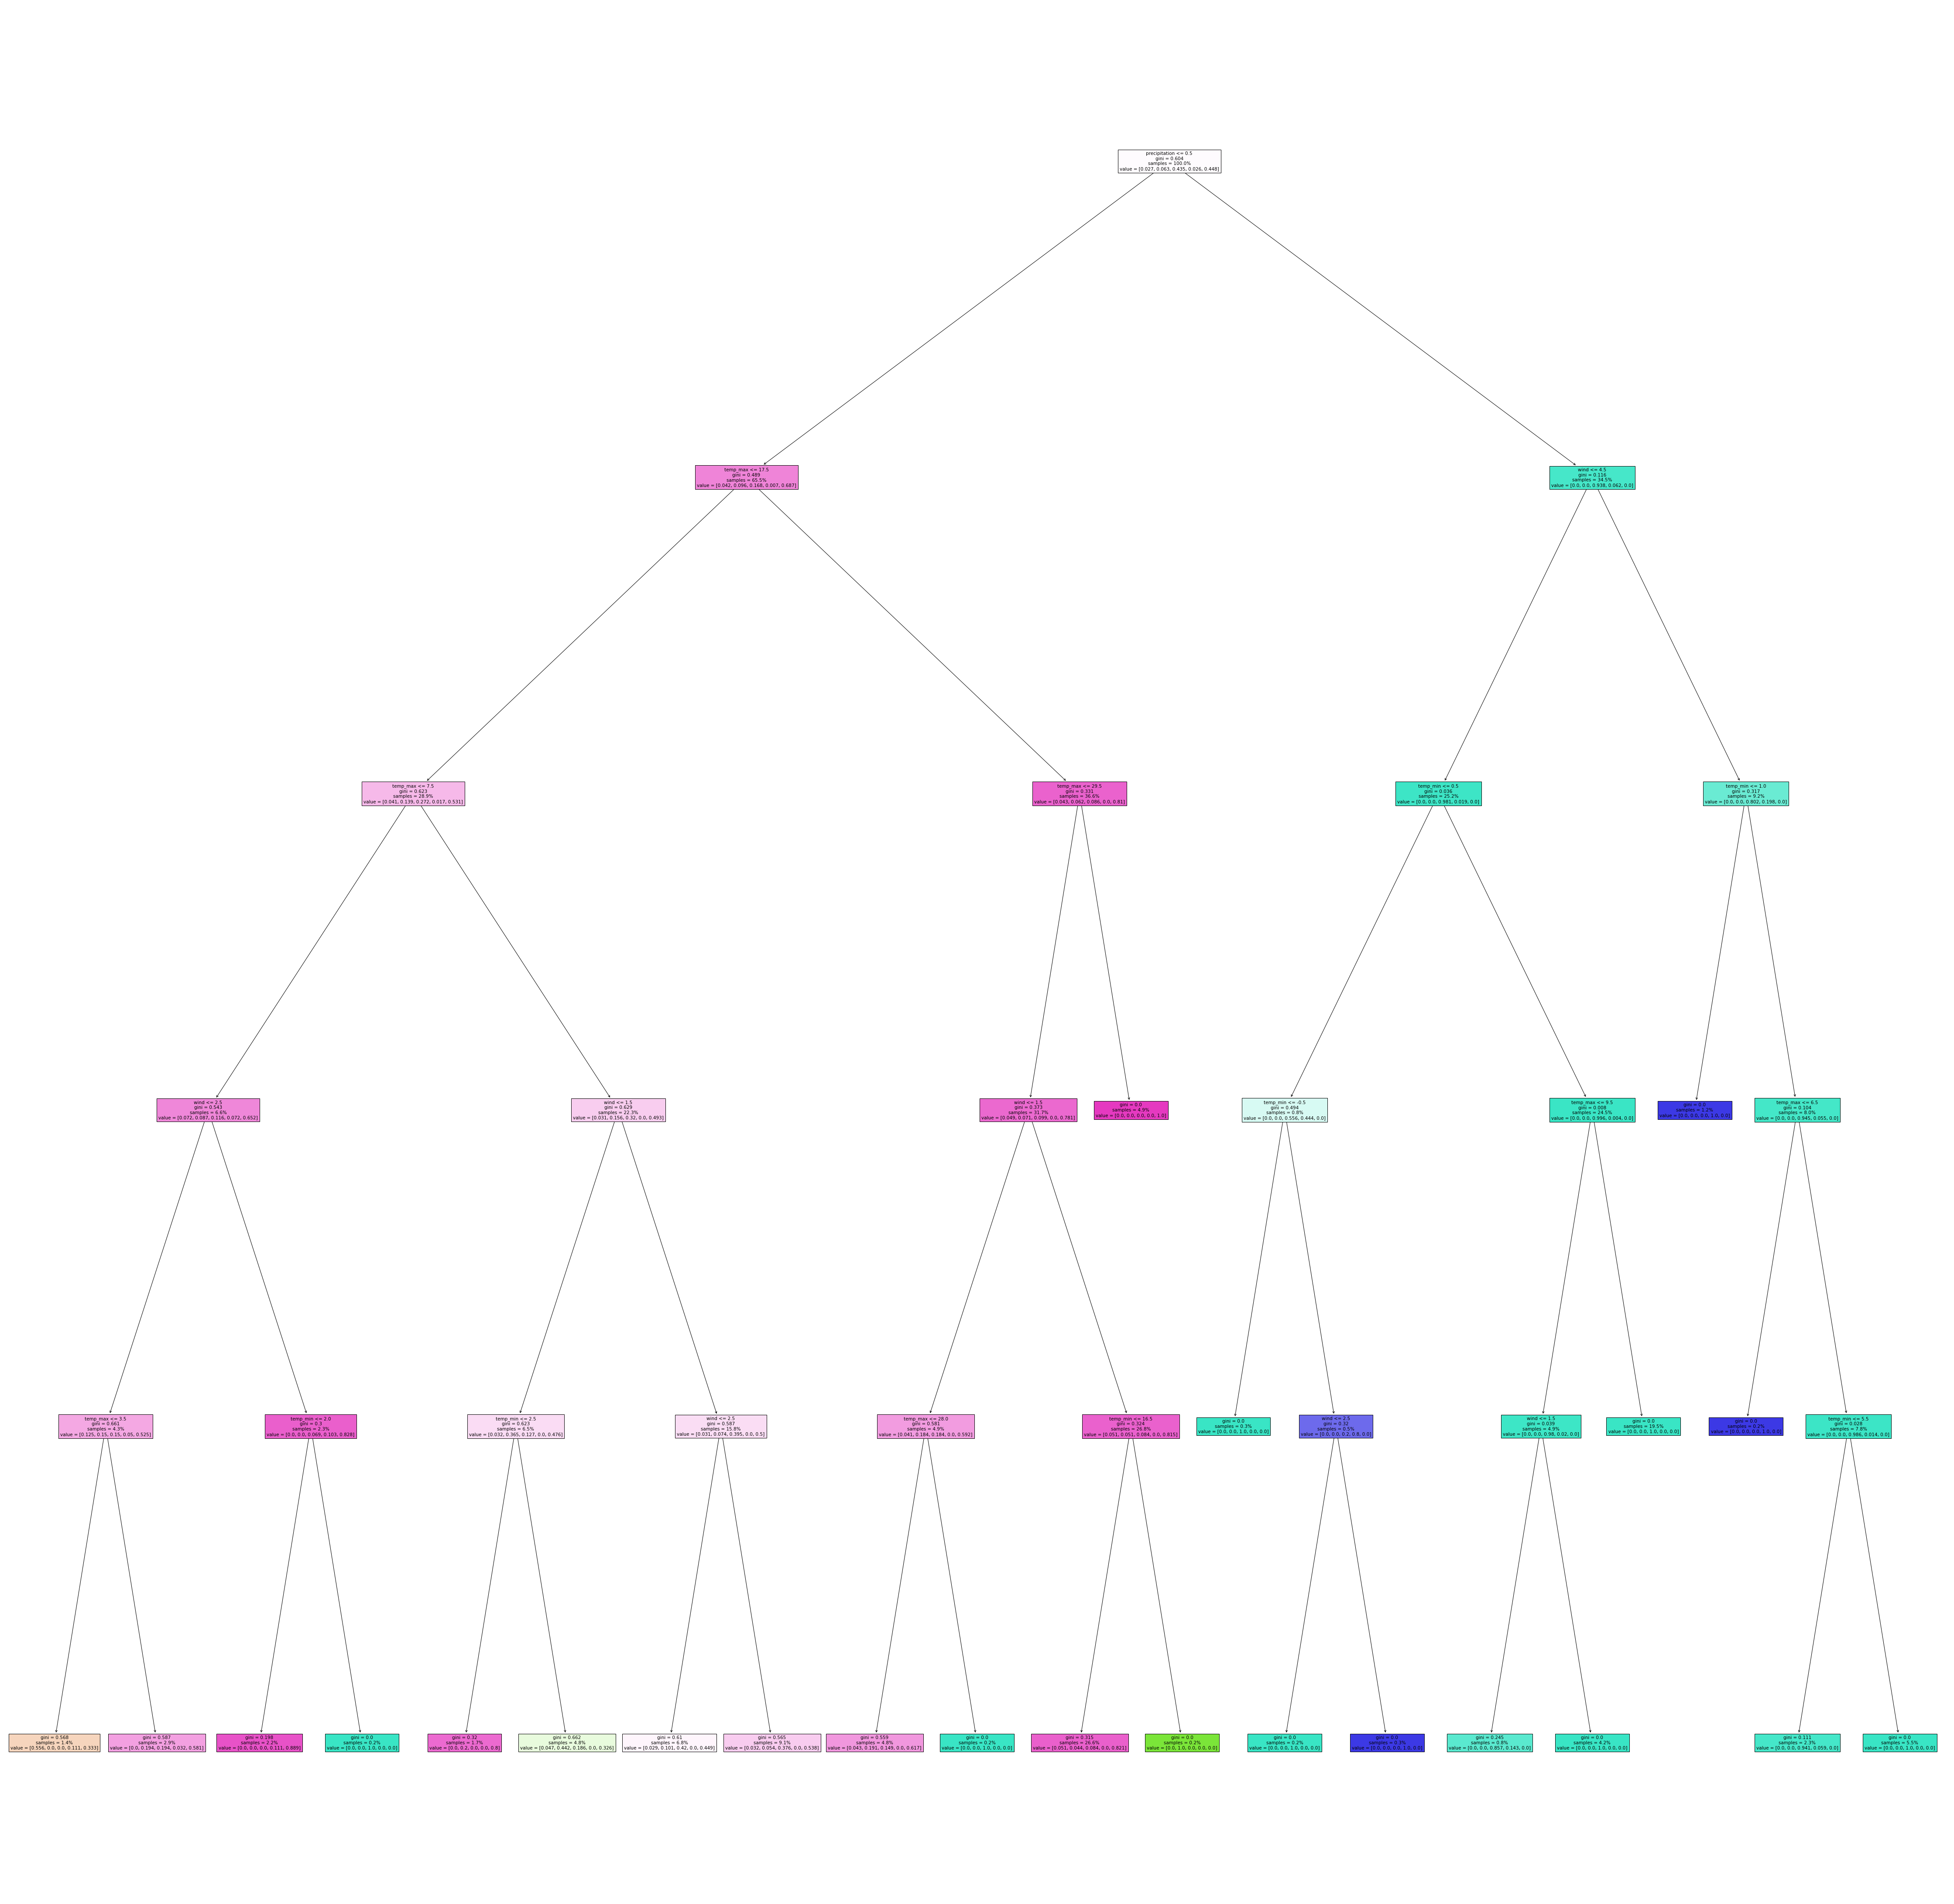

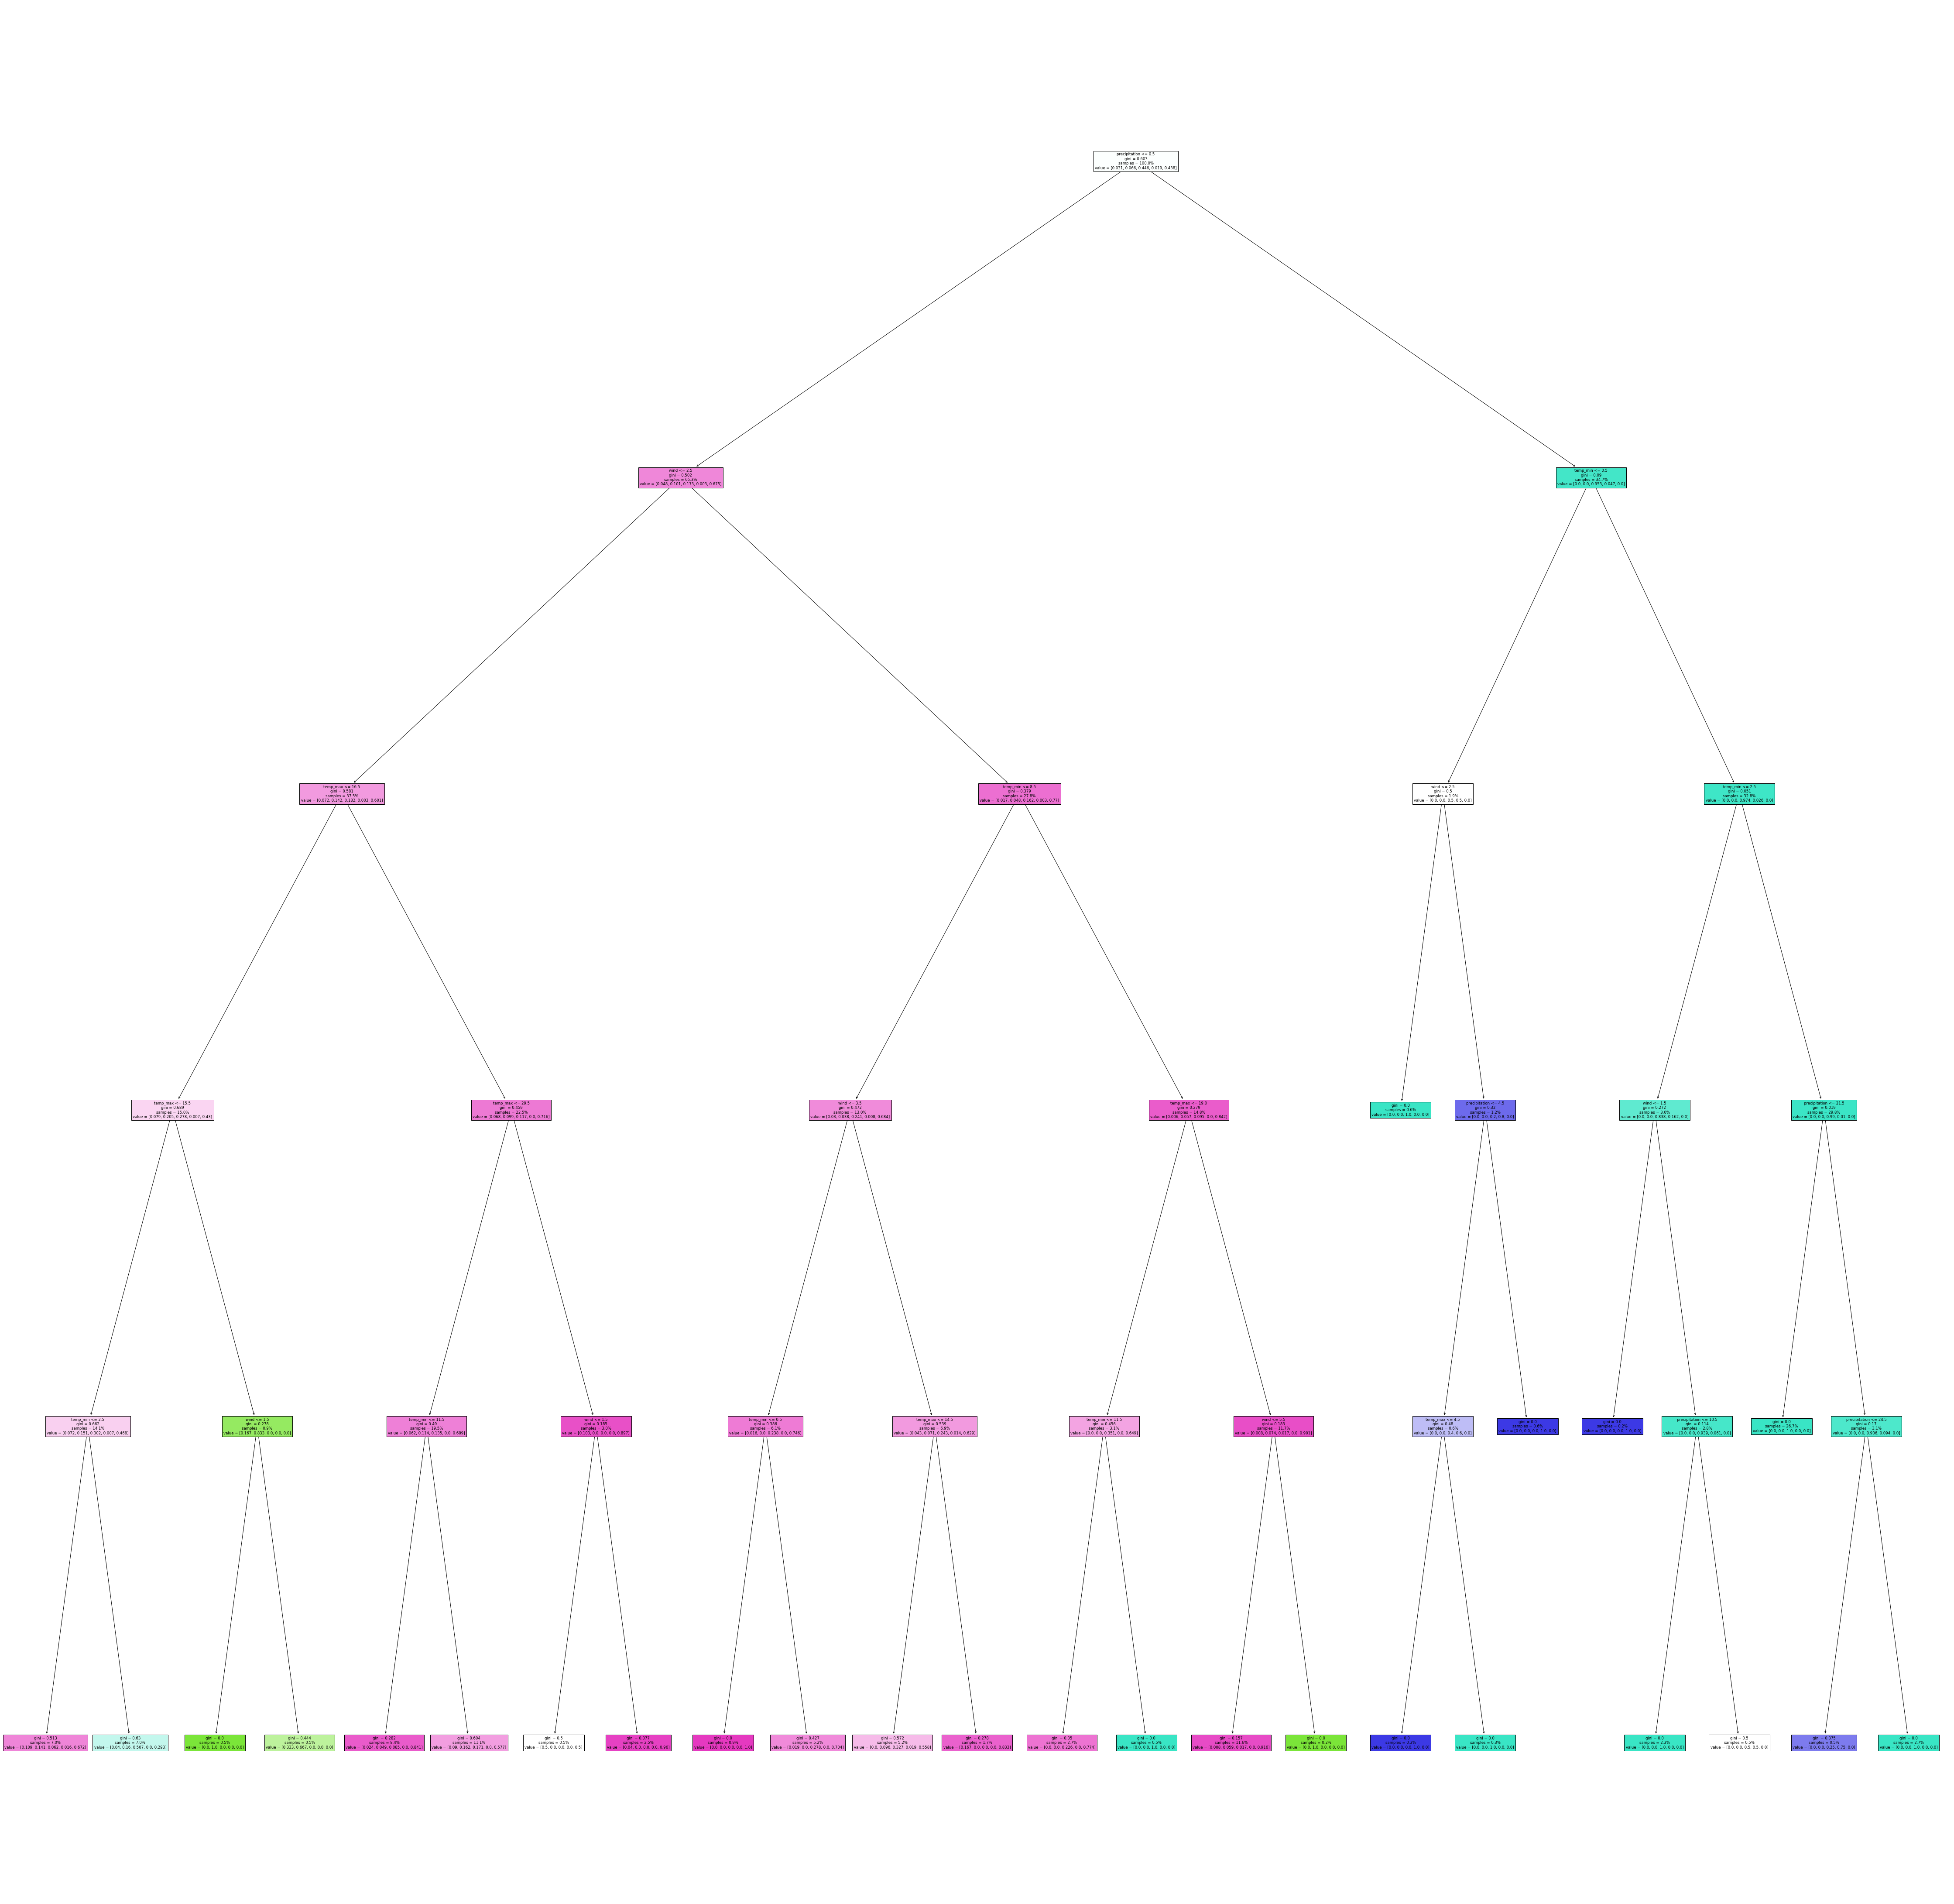

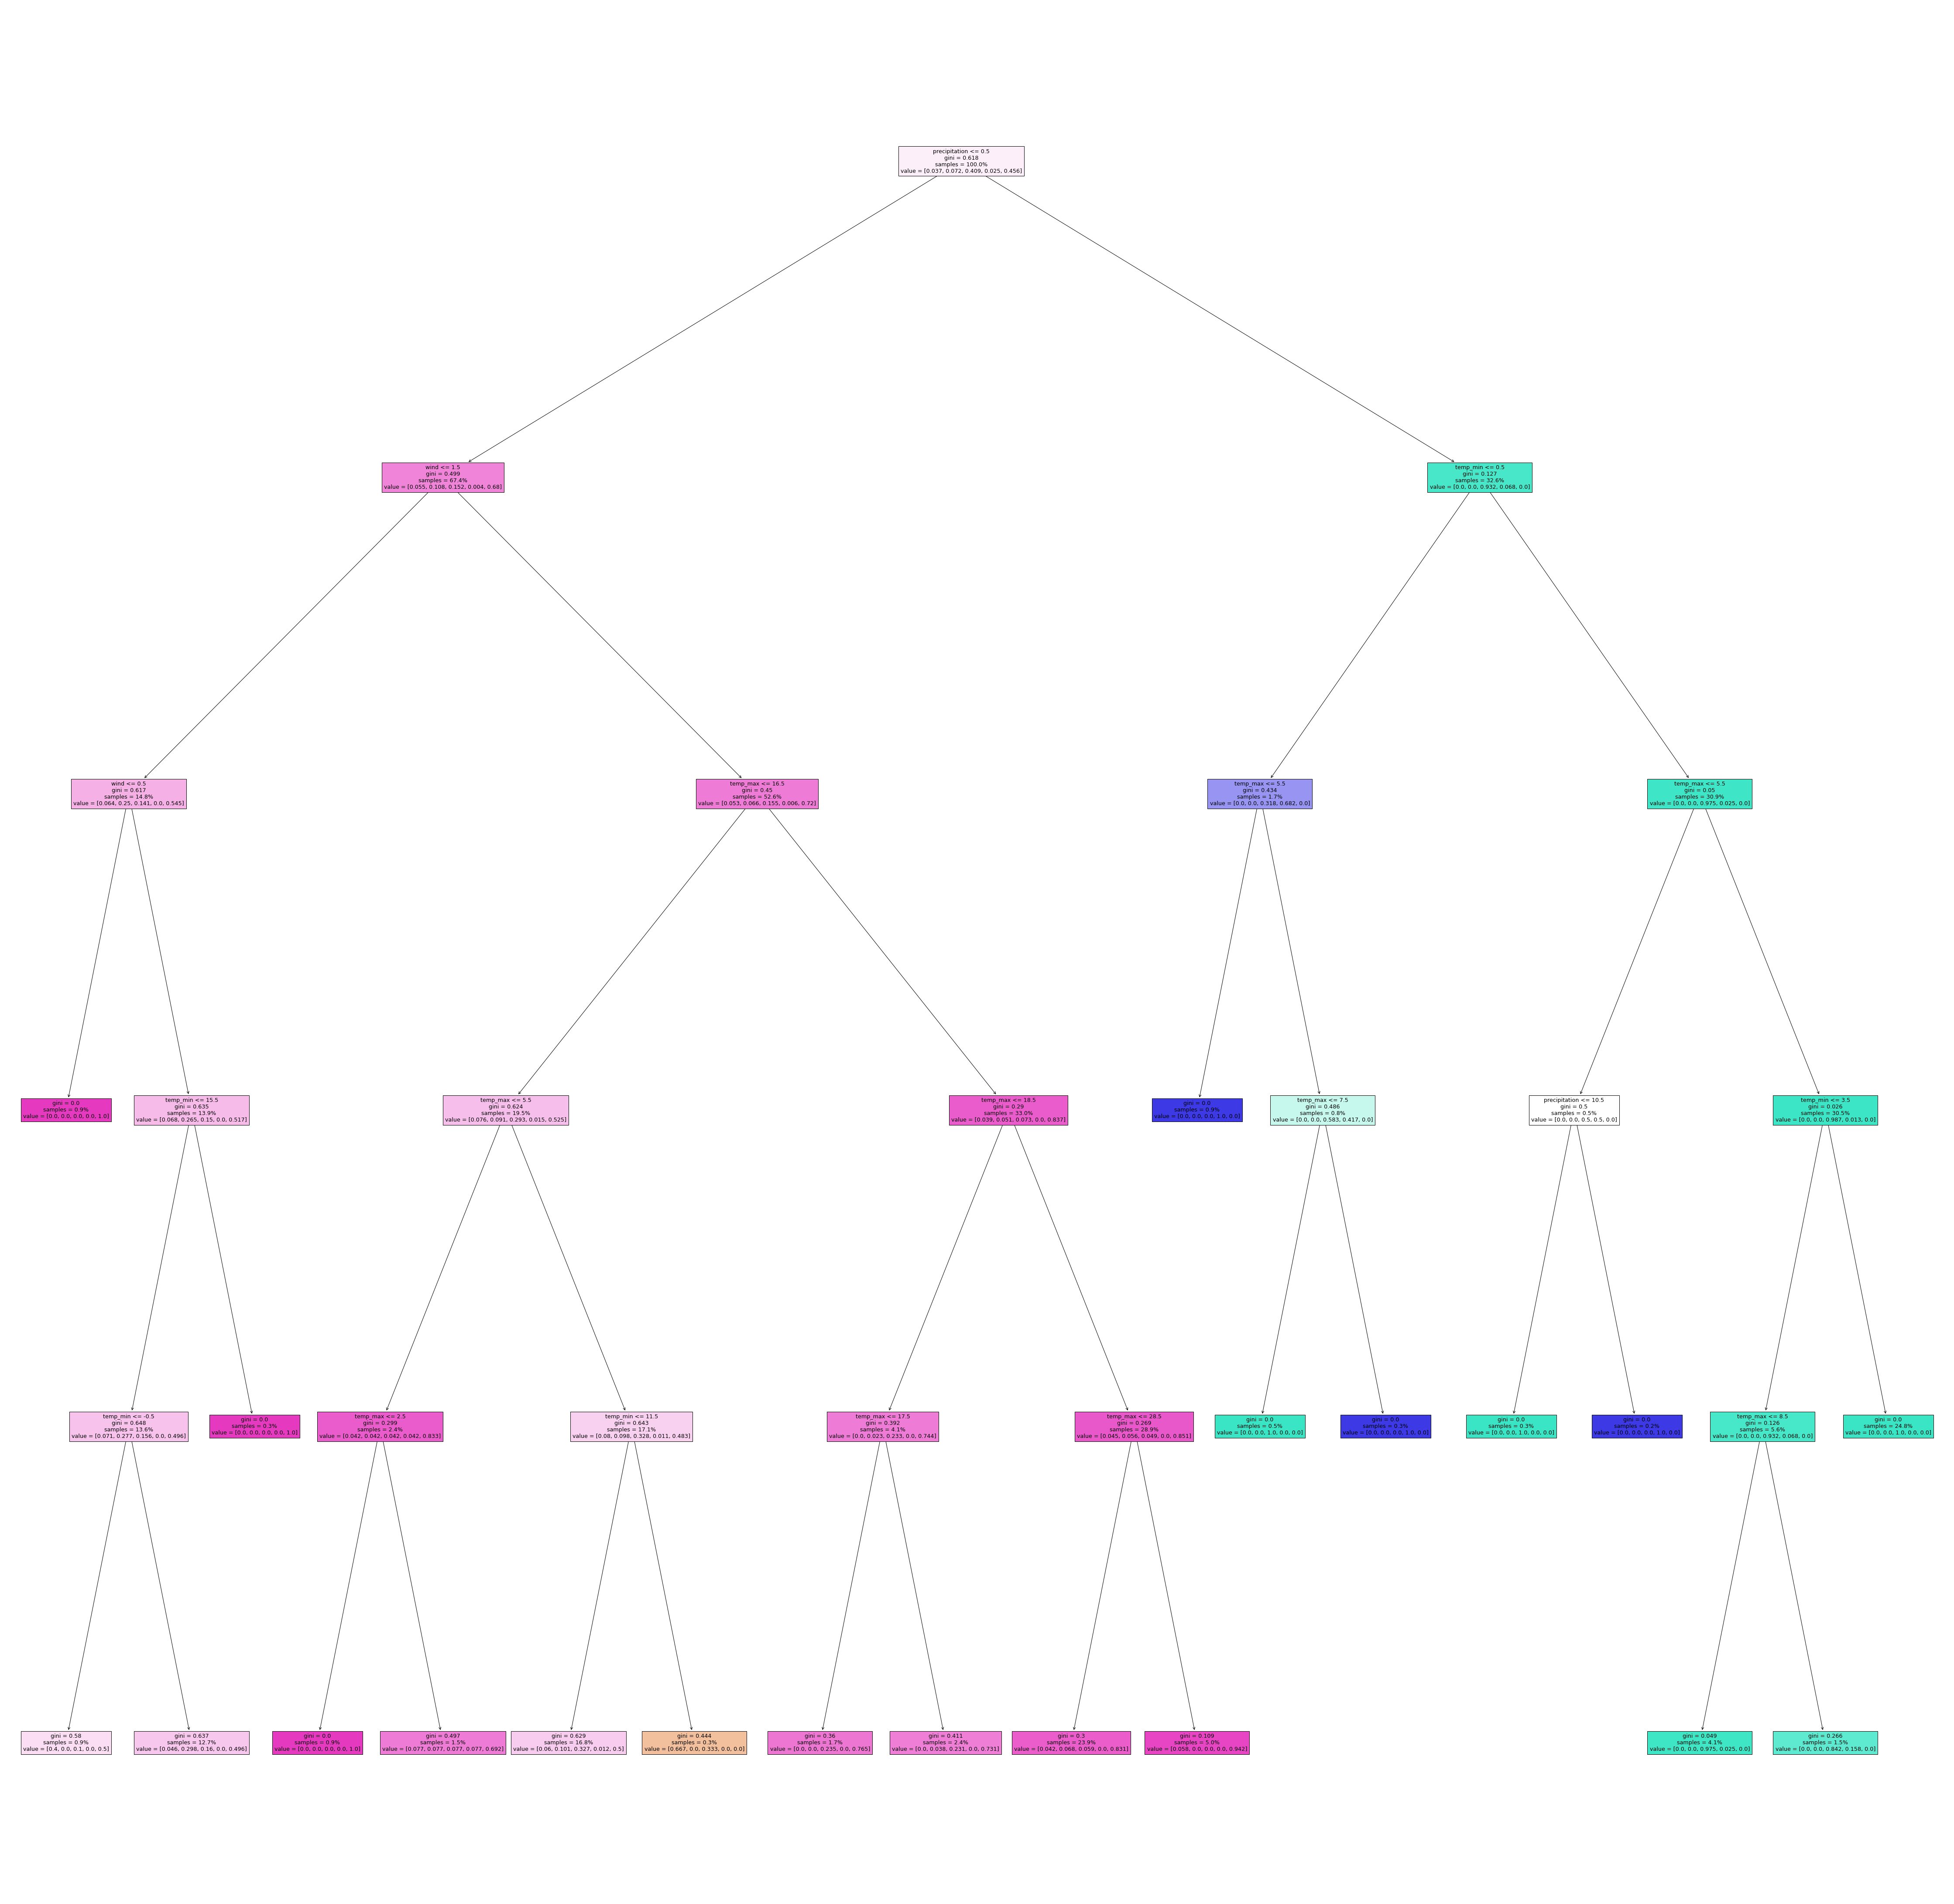

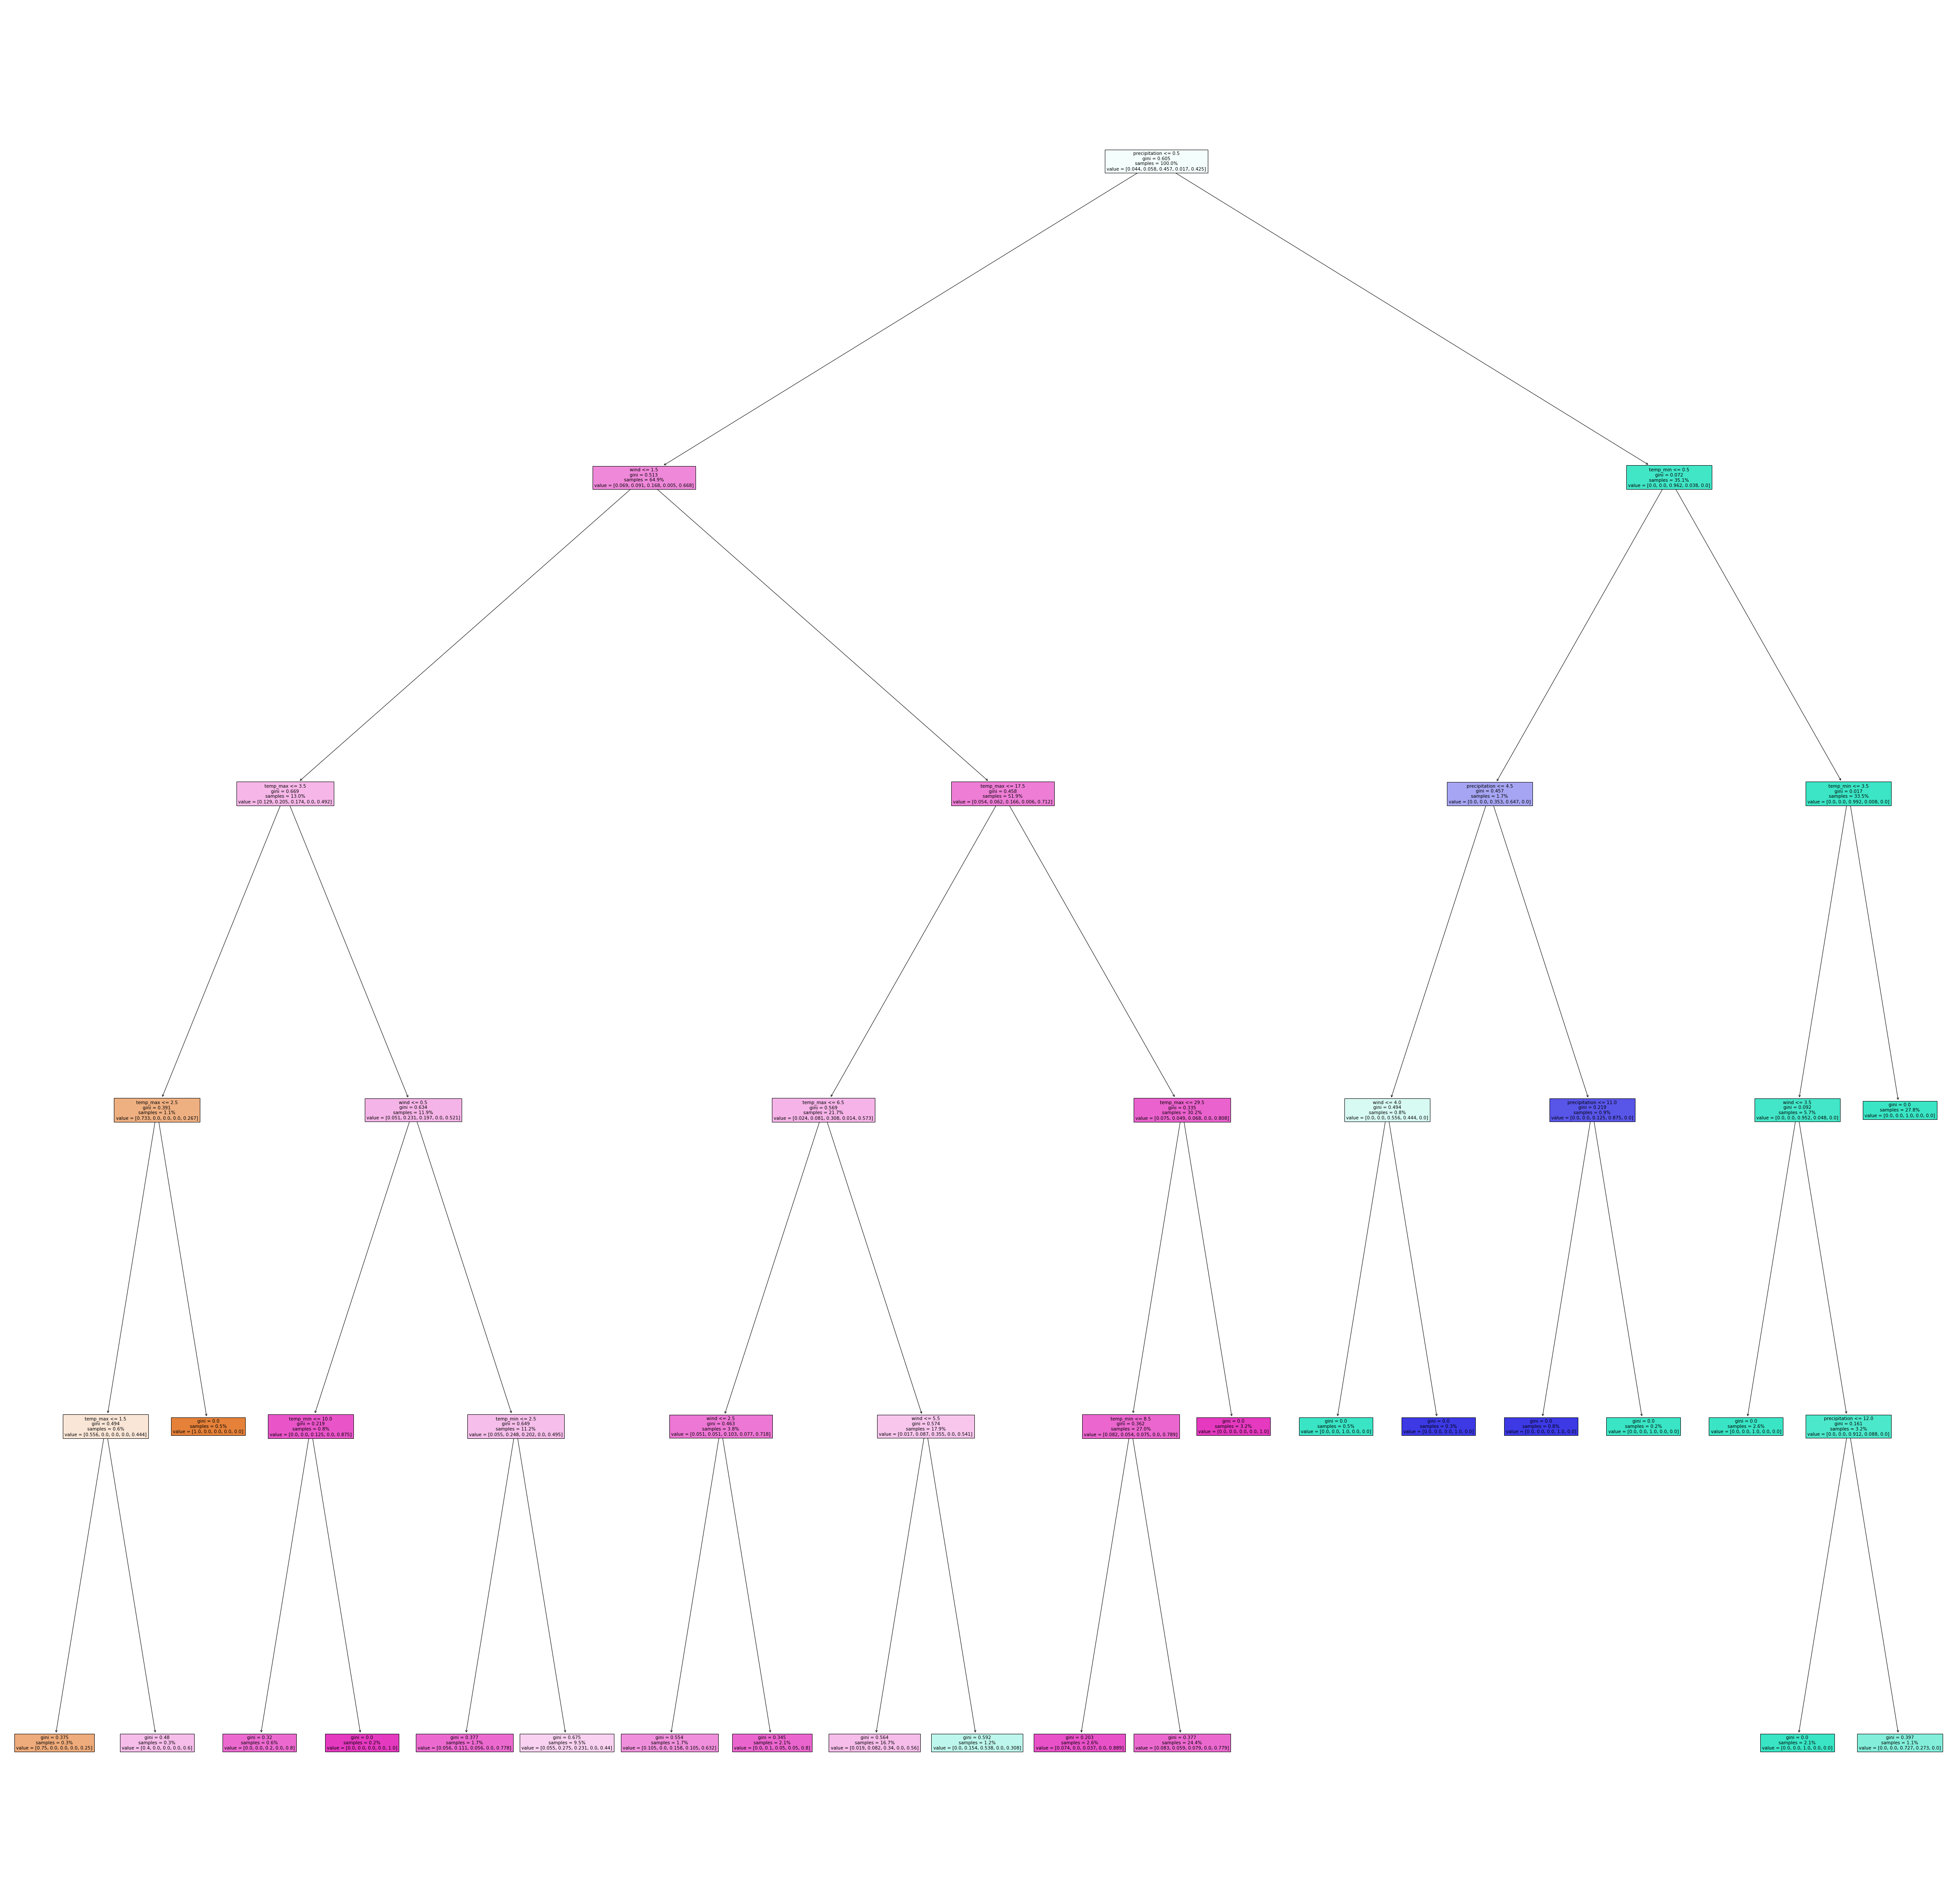

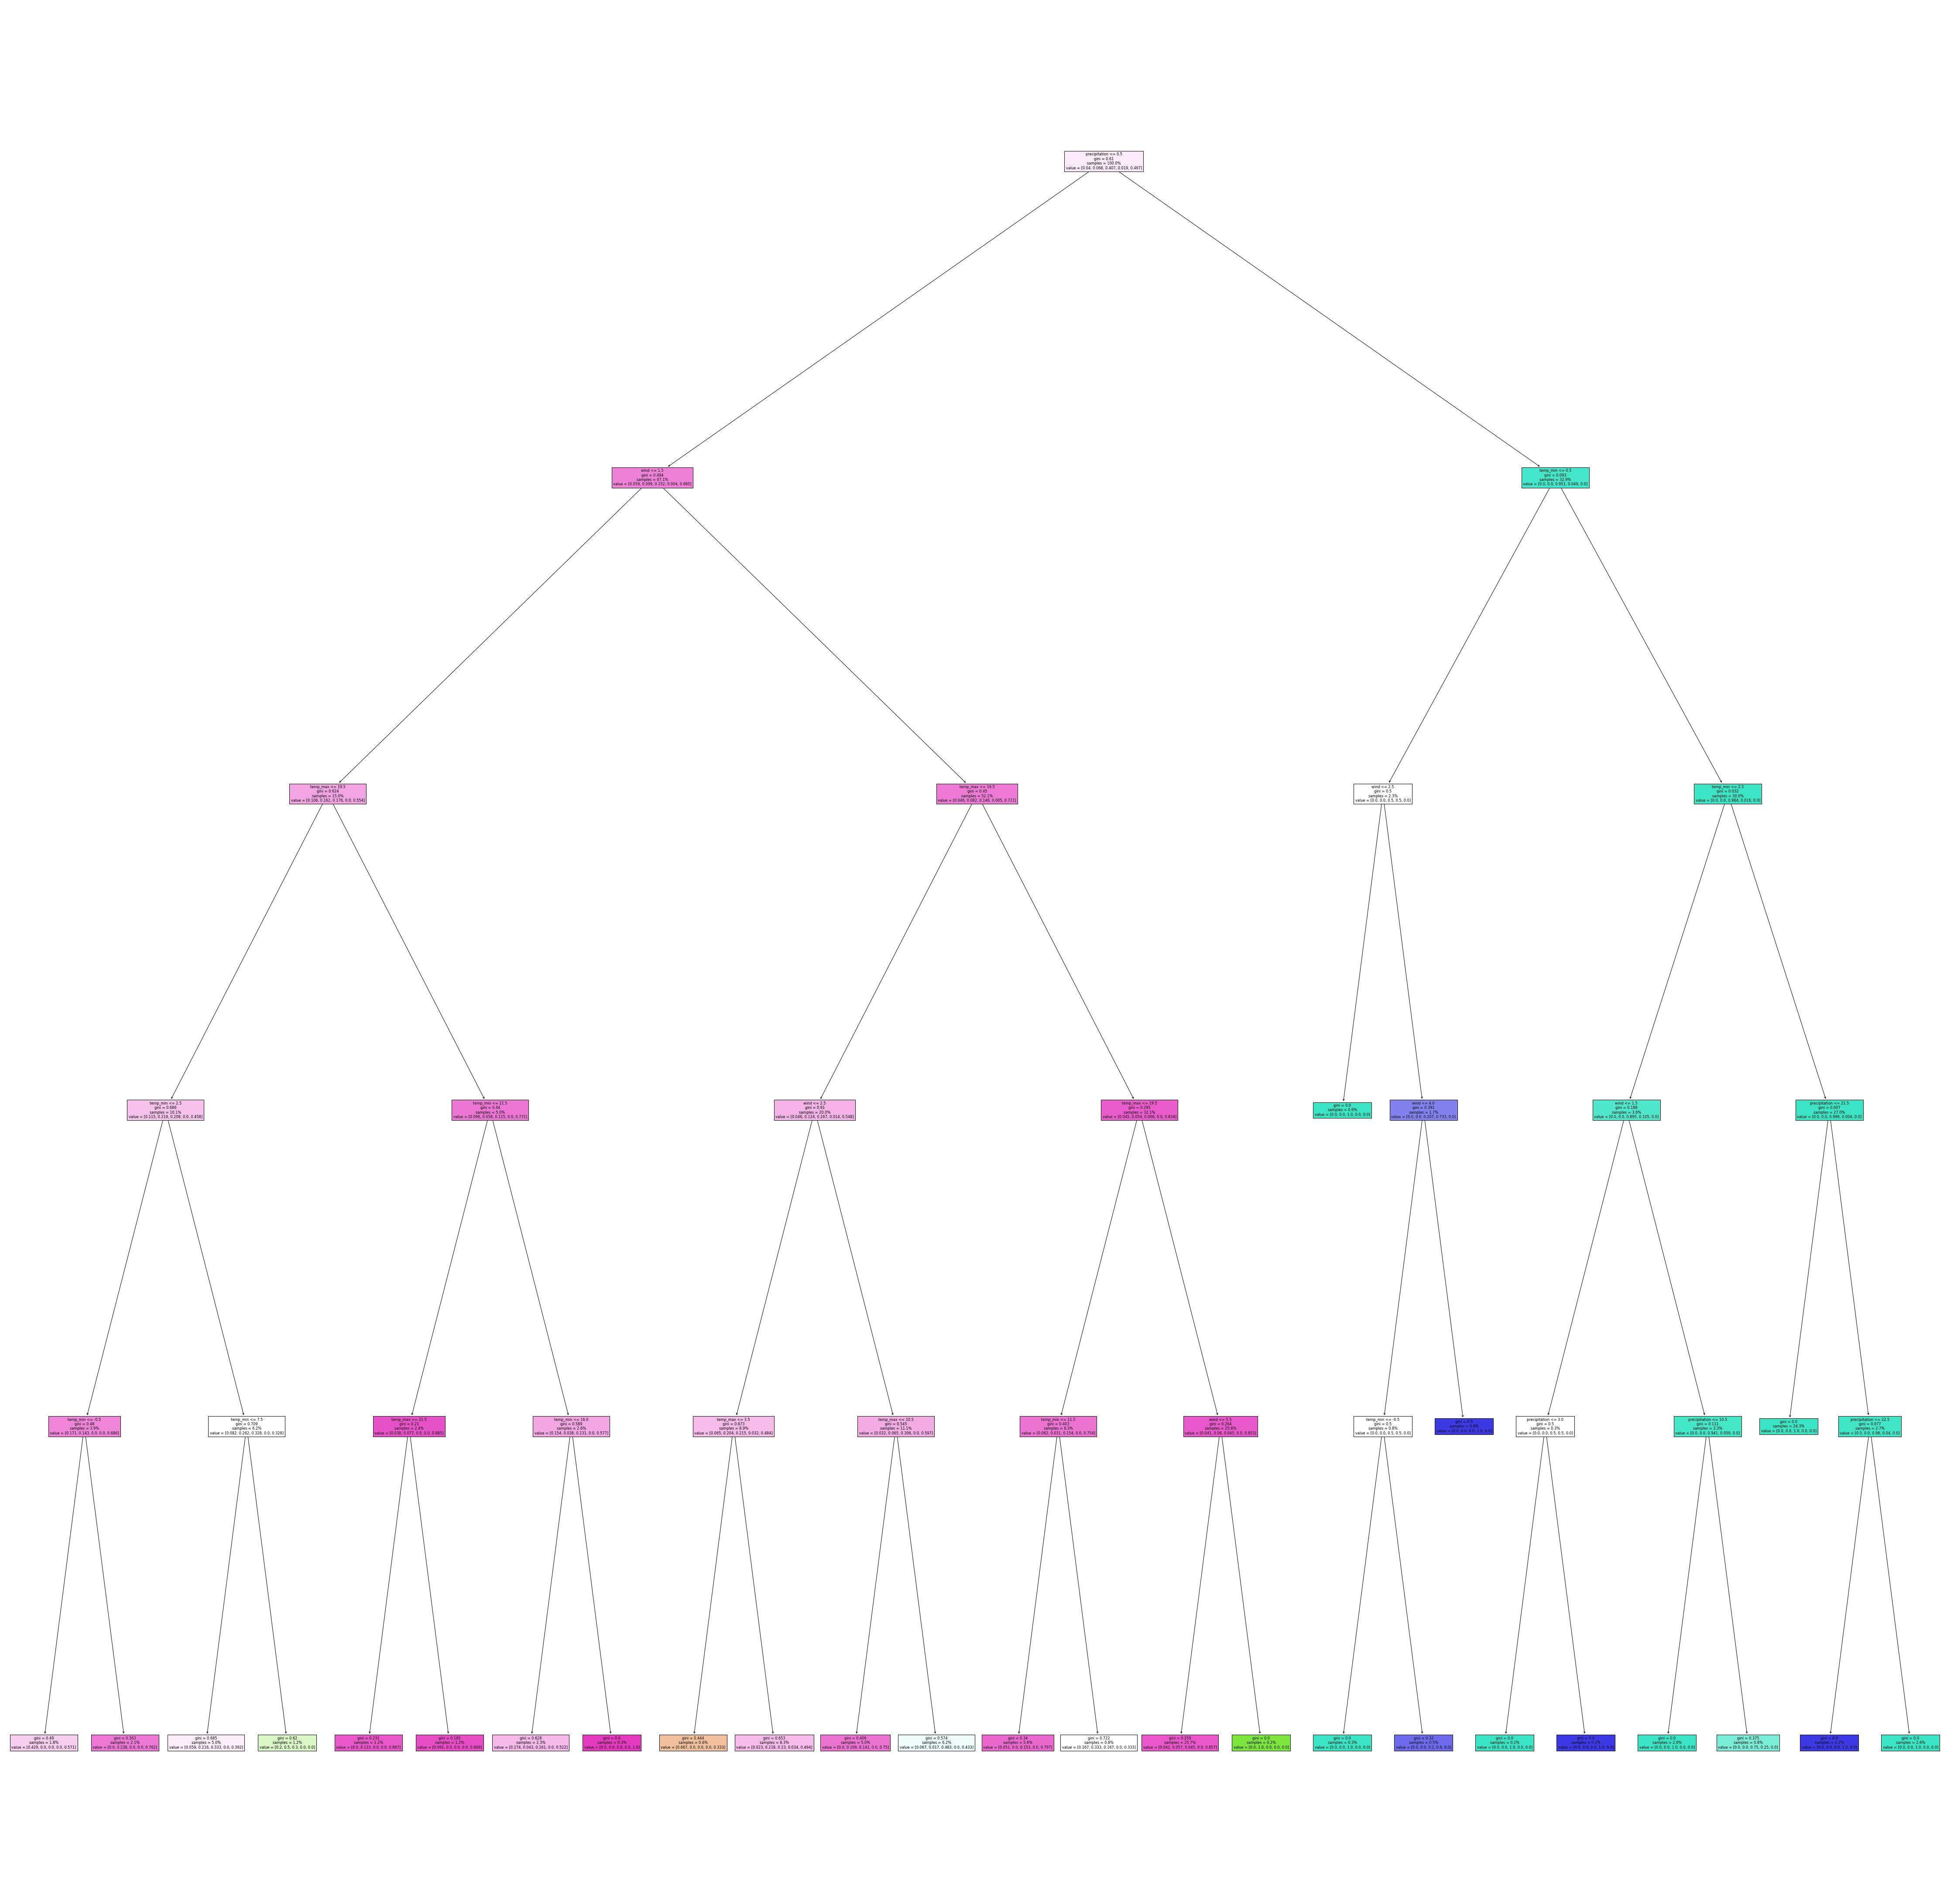

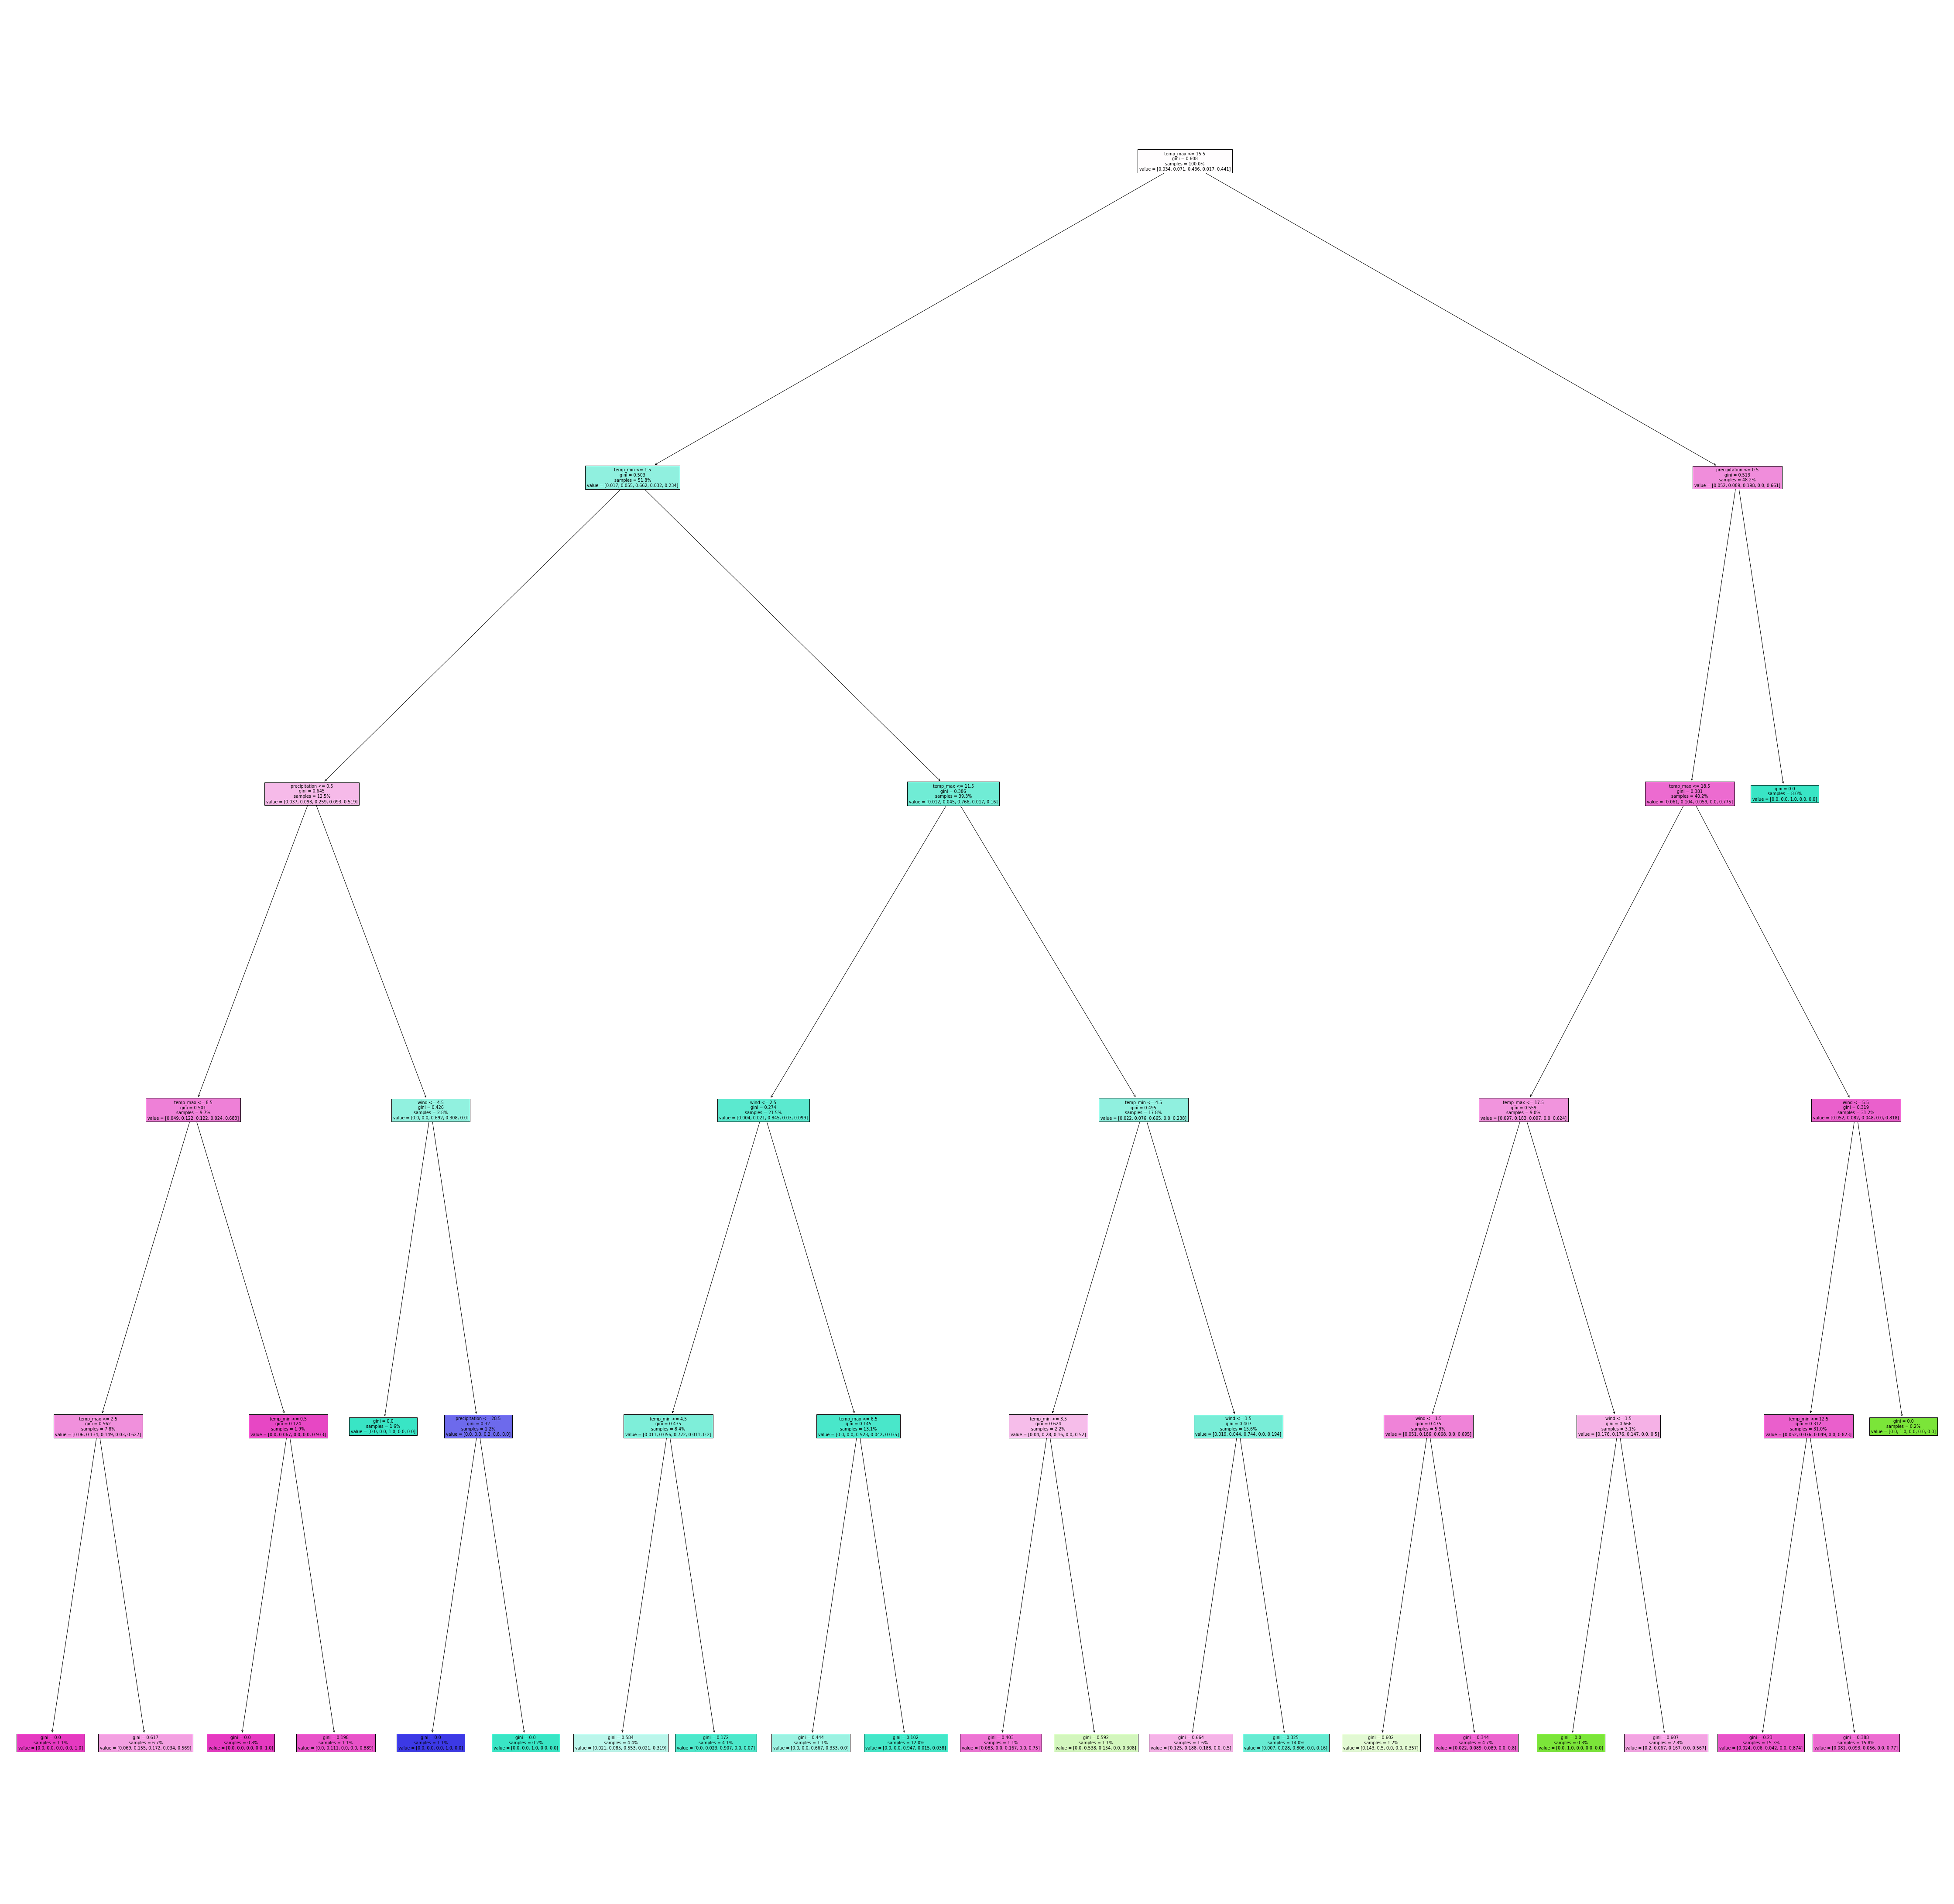

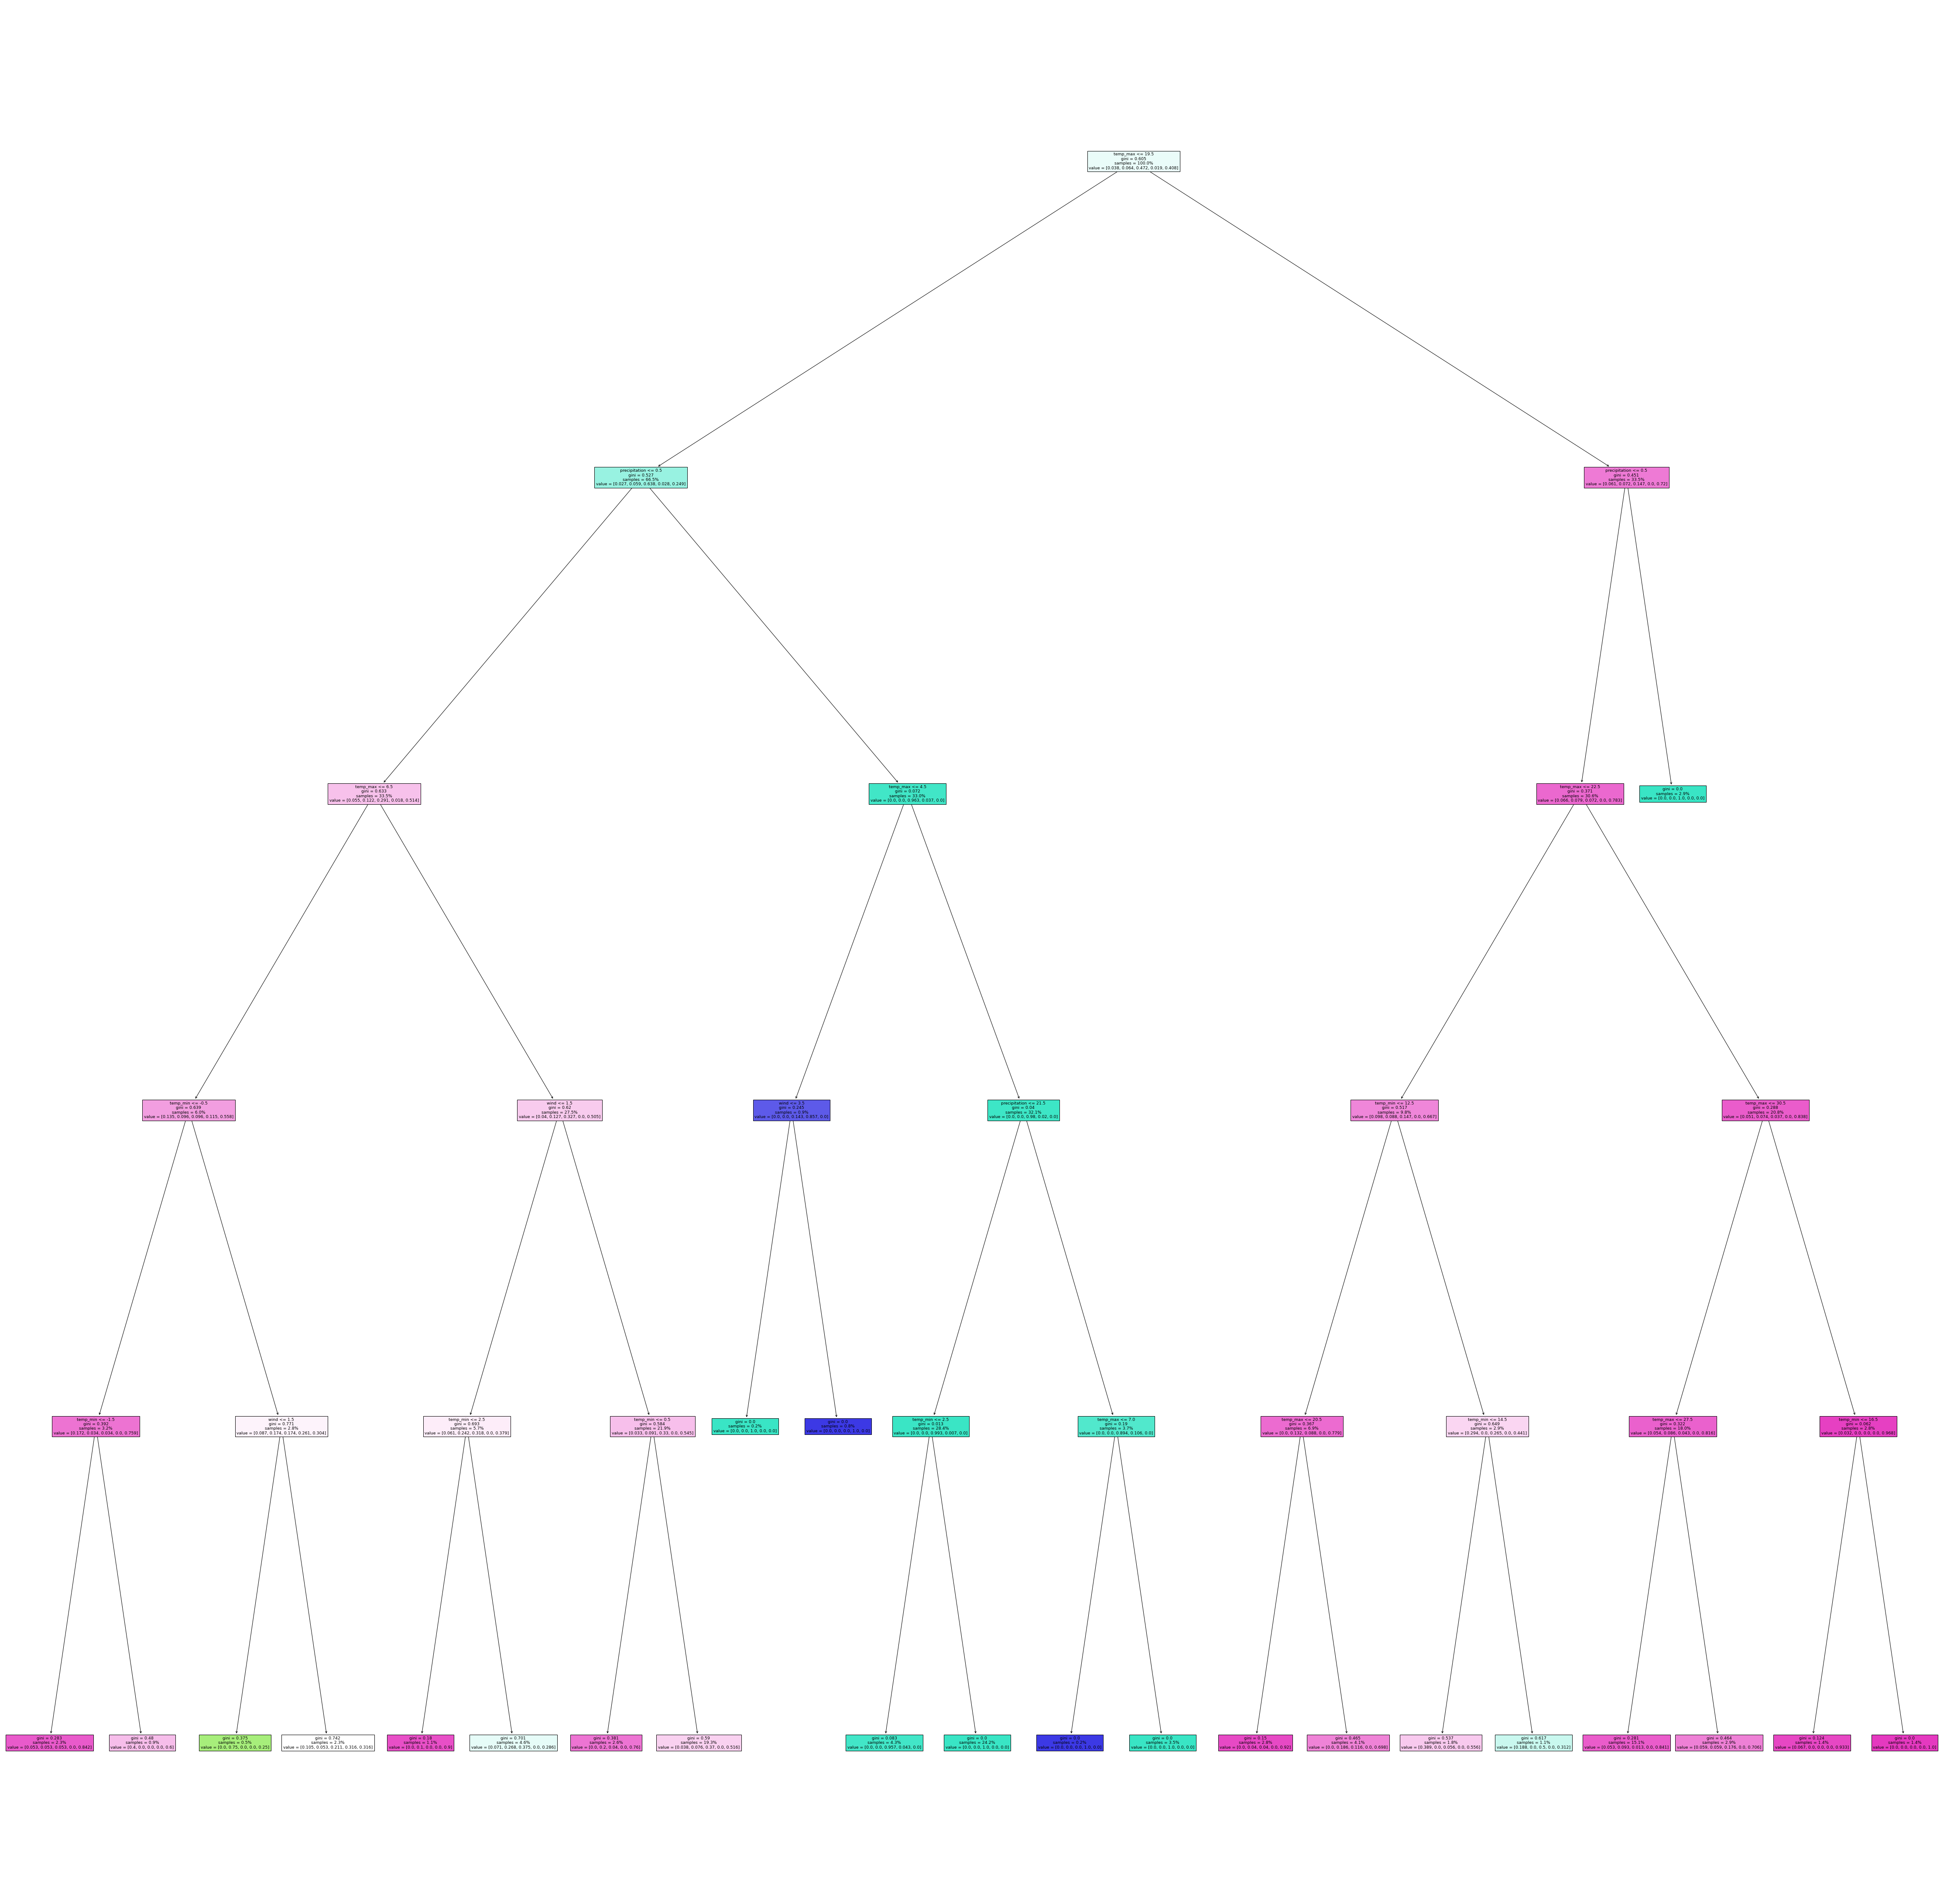

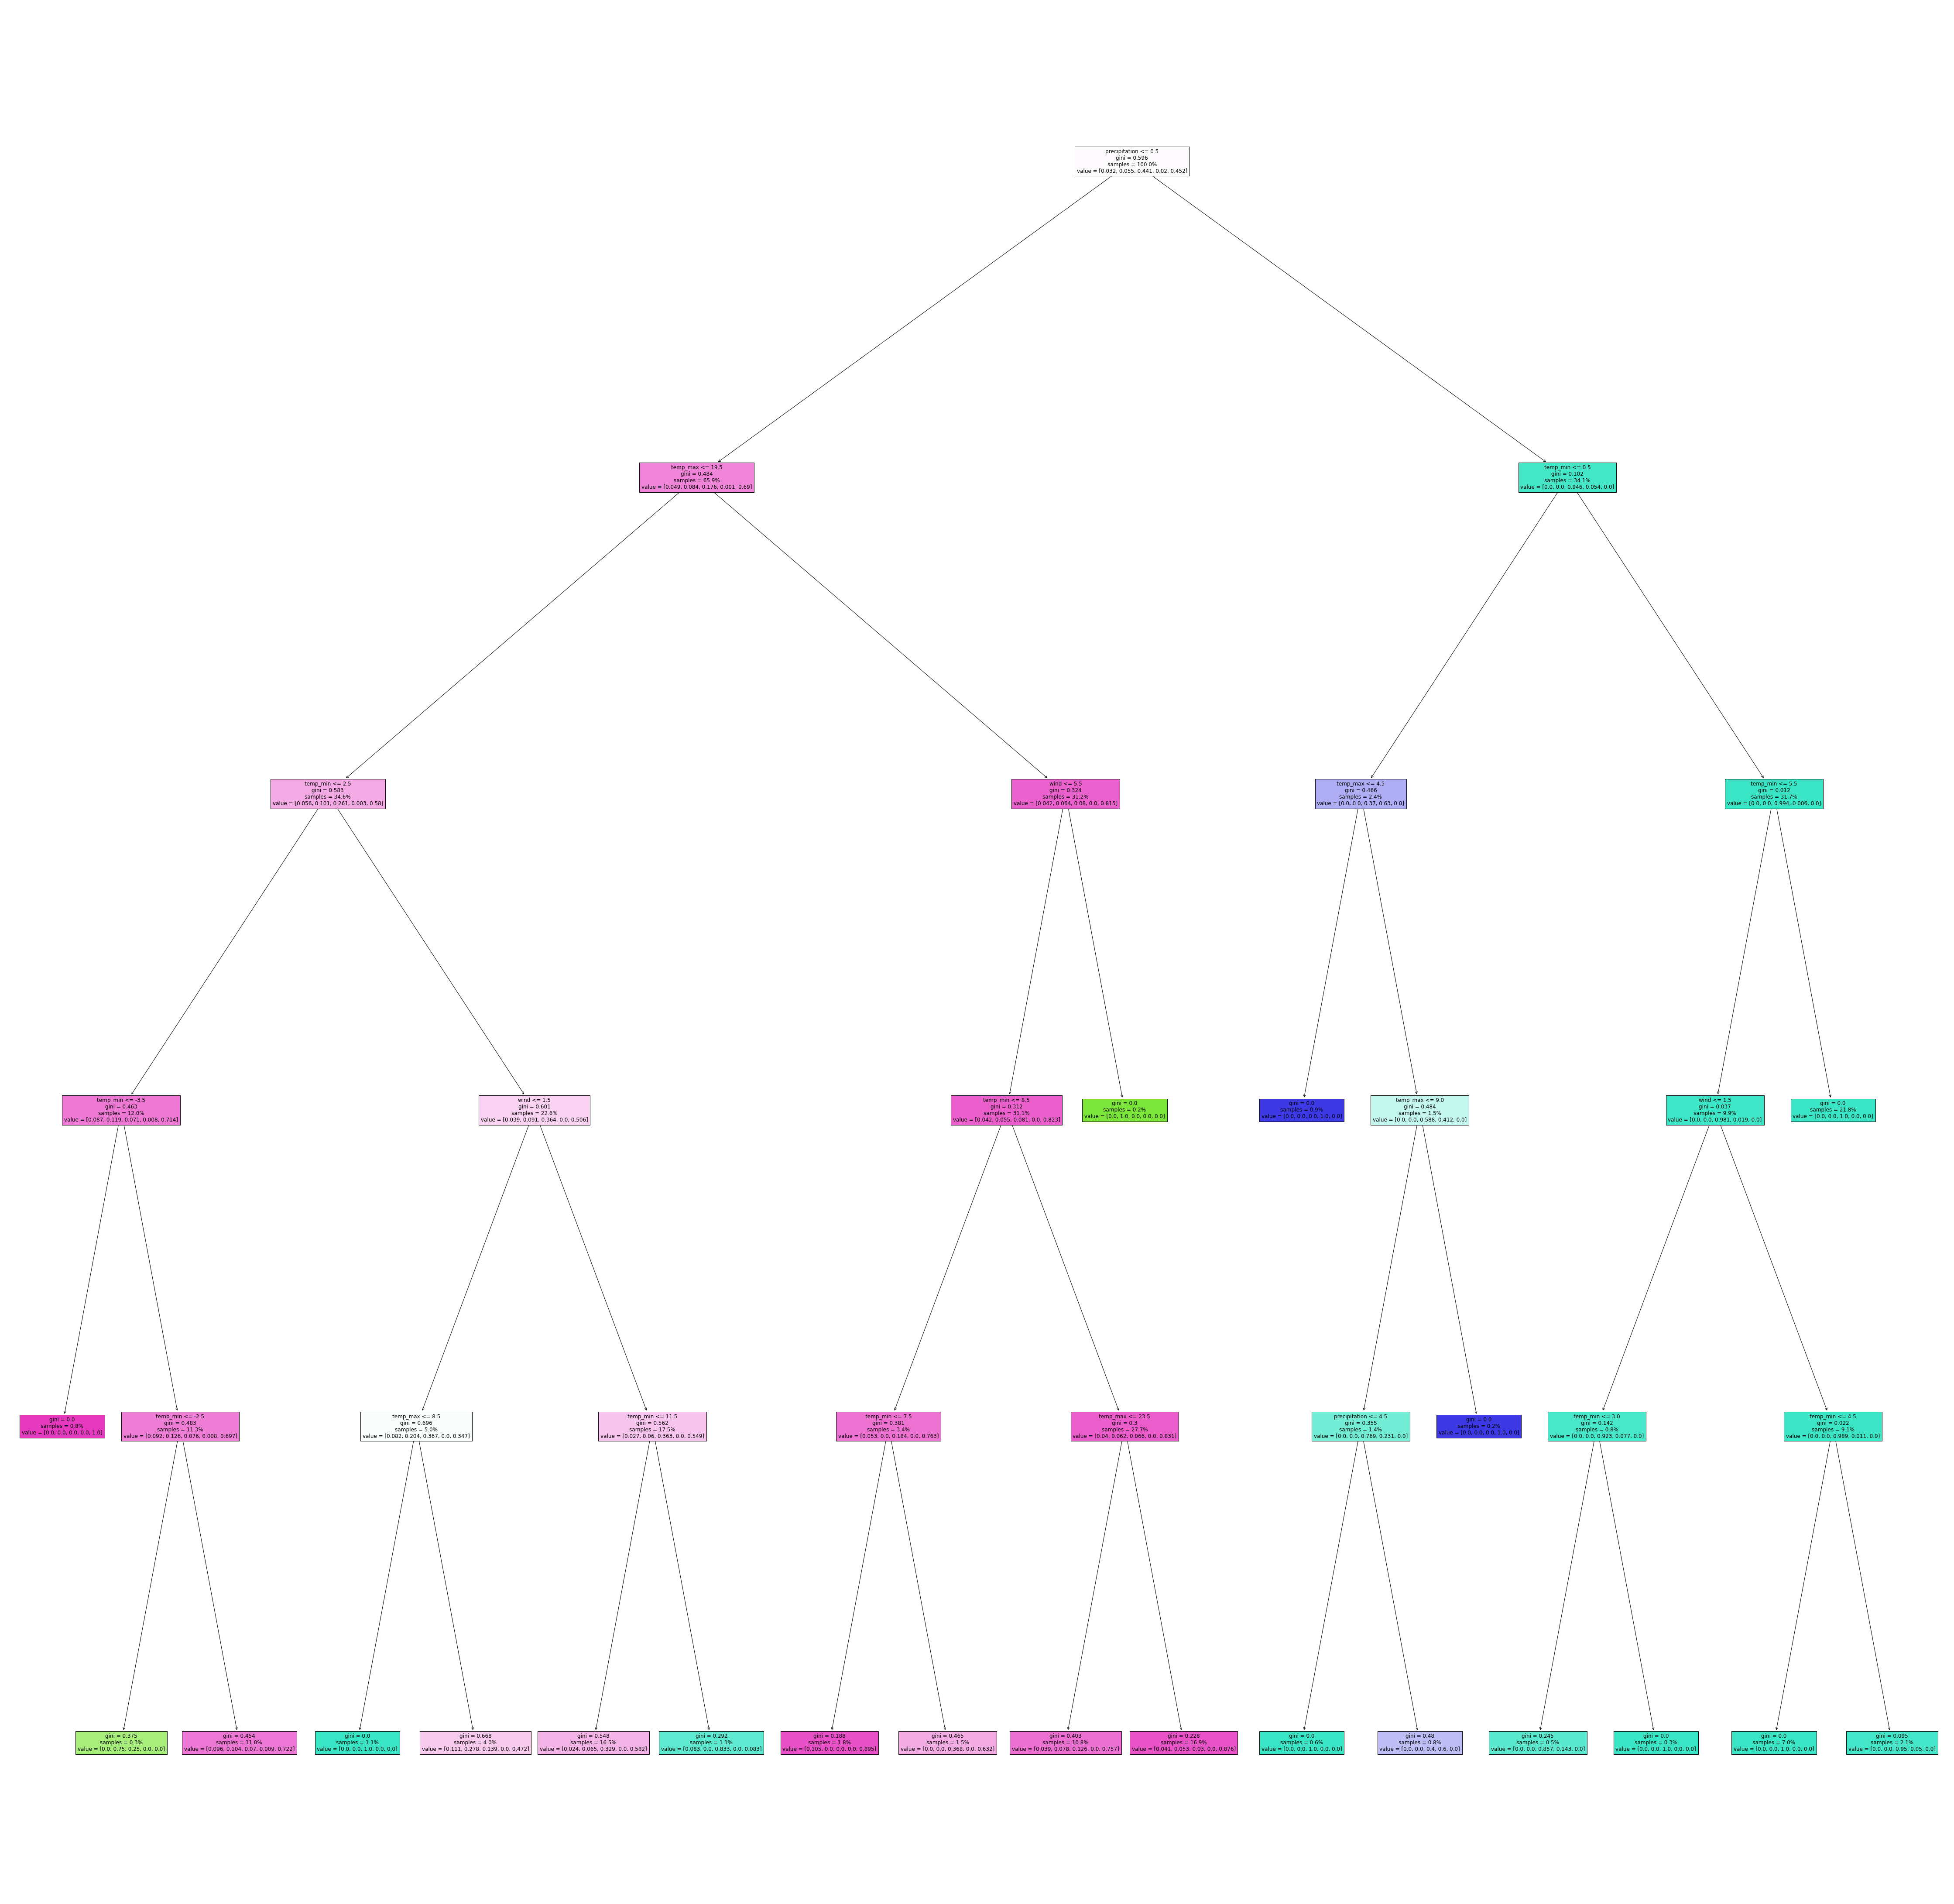

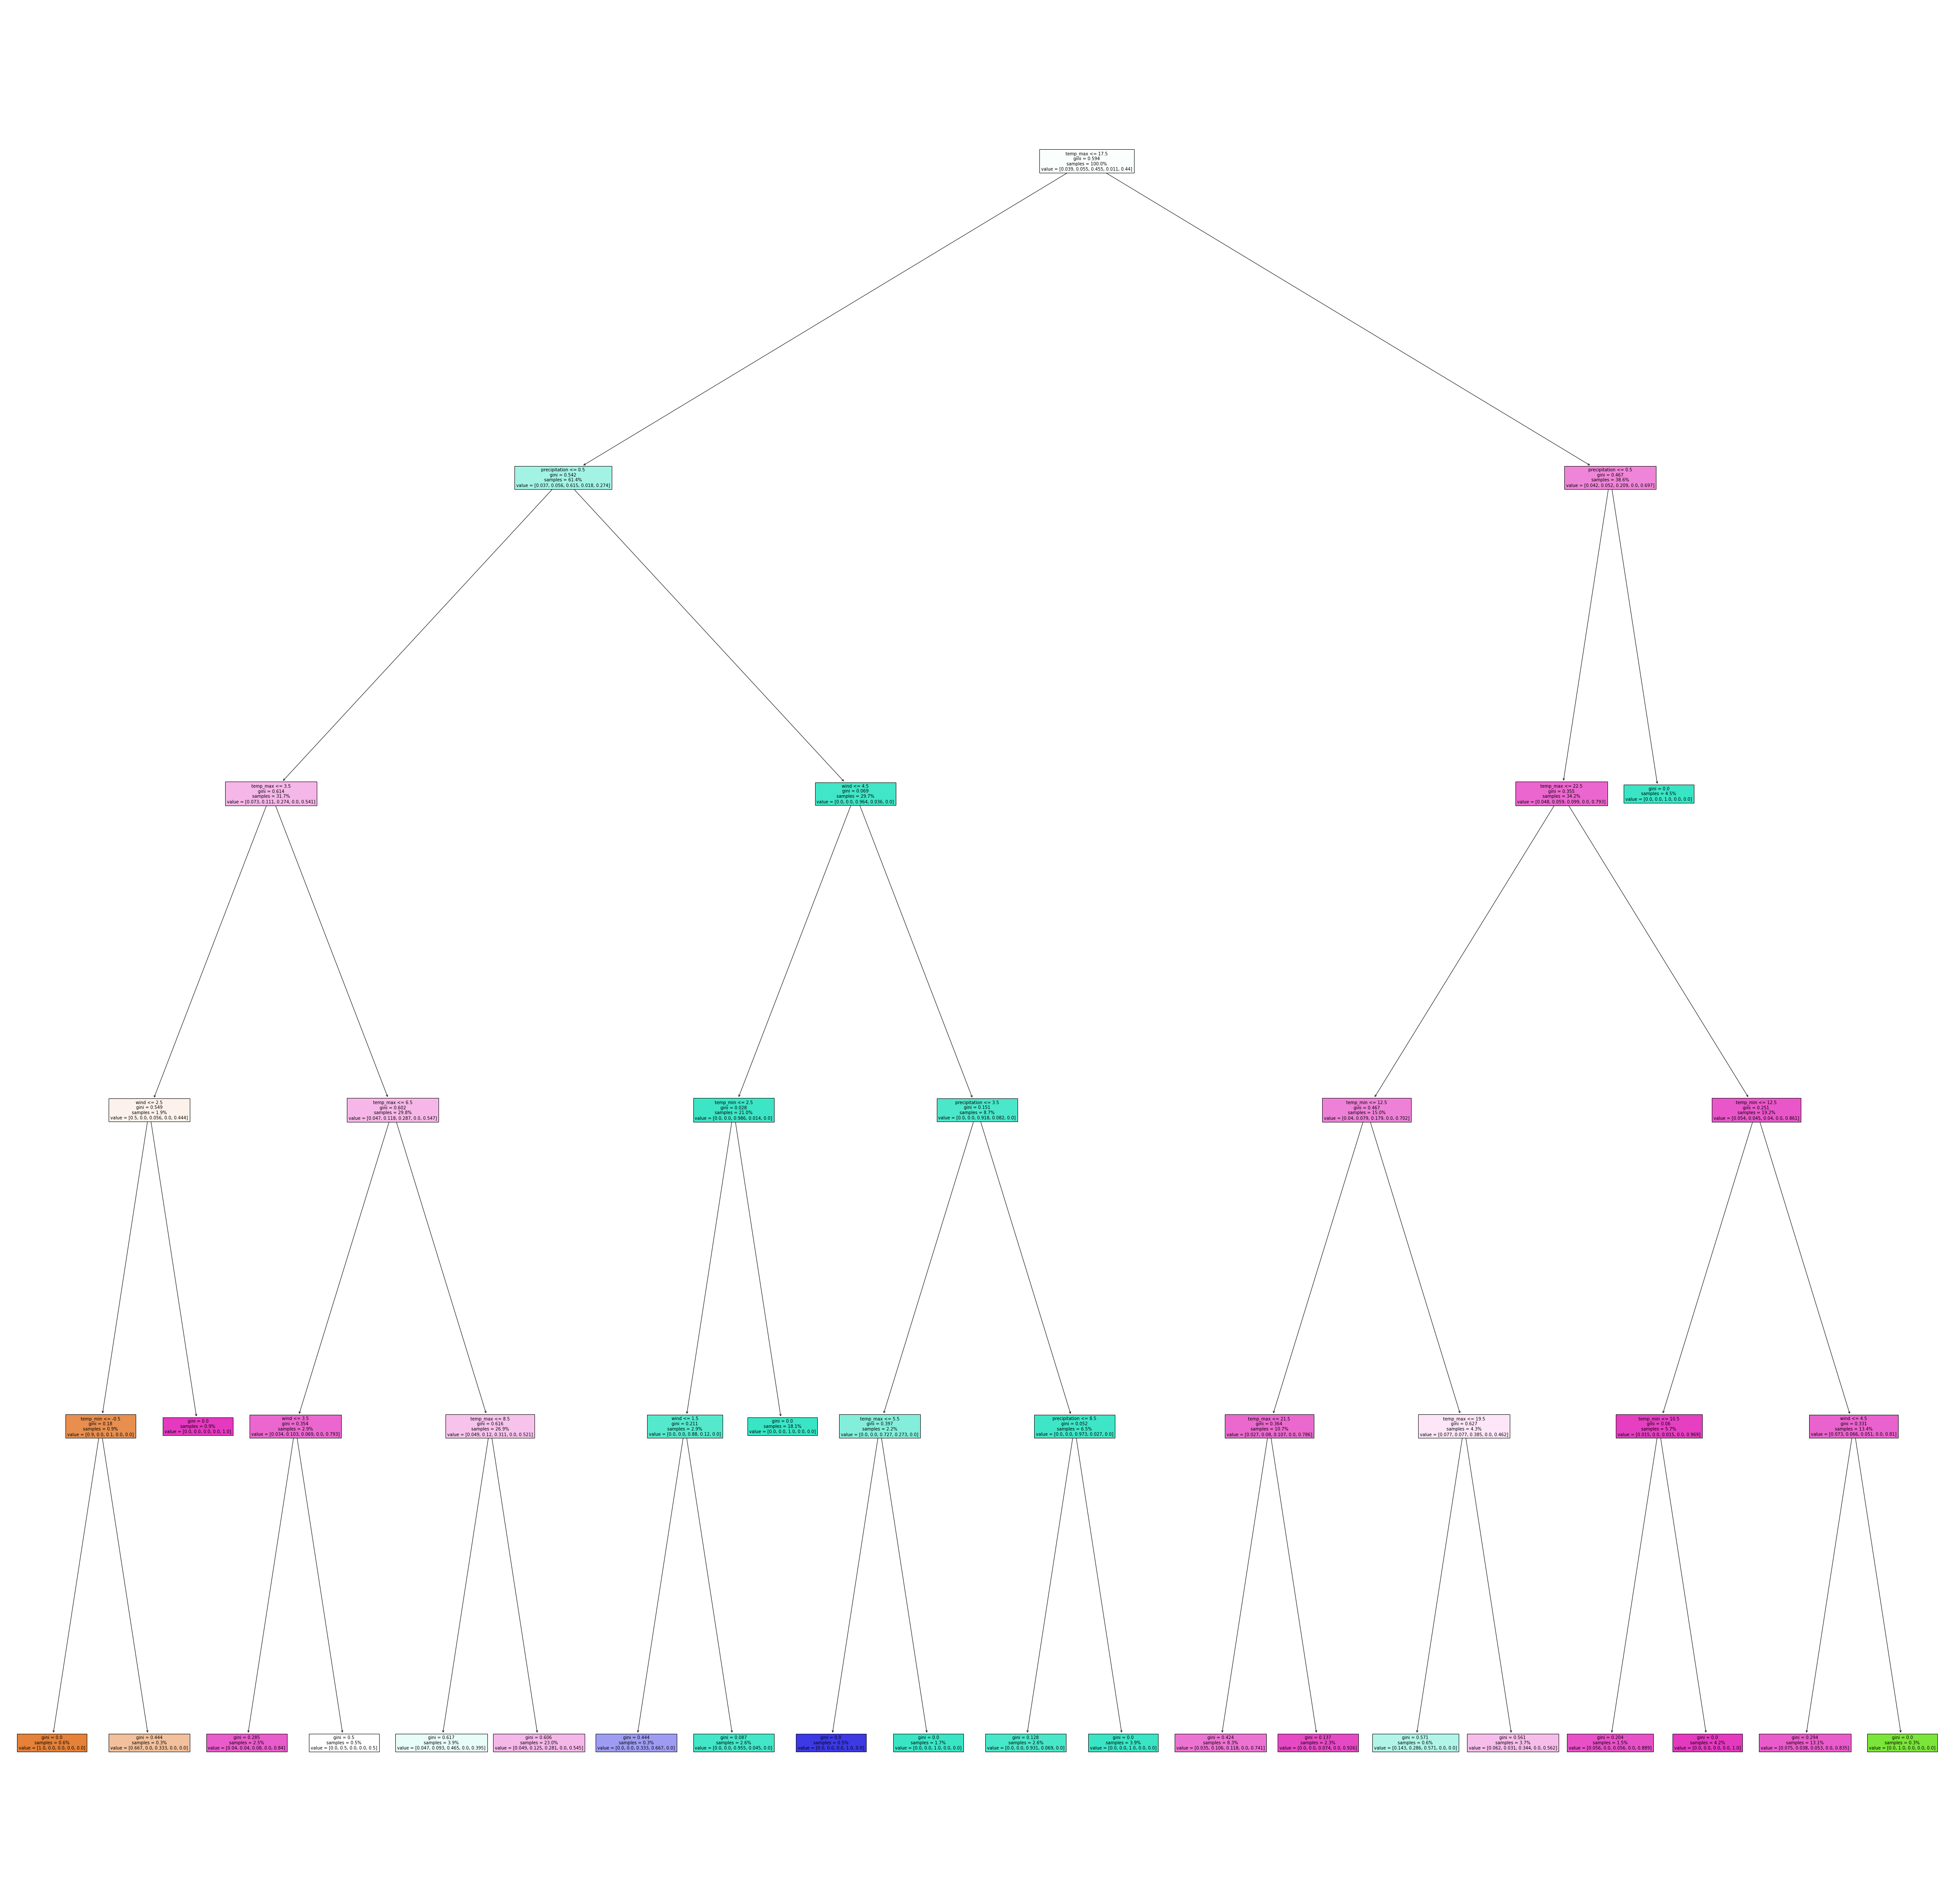

In [88]:
for i in range (0, rf.n_estimators):
    show_graph(rf, i)

In [90]:
print(rf.n_estimators)

9
